# Implementación modelo

**Kmeans (k-search, pesos iguales)**

Objetivo. Estimar la estructura natural de segmentación usando todas las variables con igual ponderación.
Preparación. Binarias en \{0,1\}; dens_int estandarizada (z-score). Imputaciones mínimas: medianas para dens_int; False para binarios faltantes (si existen).
Parrilla. k \in \{4,5,6,7,8,9,10,12\}; n_init=50; init="k-means++".
Selección. Máximo Silhouette con desempate por CH y tamaño mínimo de clúster ≥ 2%.

Resultado esperado para negocio. Perfiles a lo largo de un gradiente de adopción digital (uso, conexión, densidad de internet) que, al perfilar por edad/estrato/departamento, permitan identificar segmentos críticos y territorios con brechas.

* Silhouette (∈ [−1,1], mayor es mejor): cohesión vs separación (Euclídea).
* Calinski-Harabasz (CH) (≥0, mayor es mejor): varianza entre clústeres / intra.
* Davies-Bouldin (DB) (≥0, menor es mejor): promedio de “semejanzas” entre clústeres.
* Adjusted Rand Index (ARI) (∈ [−1,1], 0 ~ azar, 1 idéntico): estabilidad/consistencia de particiones.



In [1]:
# ============================================
# 0) Imports y utilidades
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

# -------- Helpers de preparación --------
FEATURES = [
    "Servicios_Telecomunicaciones_No",
    "Servicios_Telecomunicaciones_Si",
    "Dispositivos_hogar_No",
    "conexion_hogar_si",
    "interrupciones_si",
    "frec_uso_si",
    "dens_int",
]

# Variables SOLO para perfilar (no entrenan el modelo)
SOCIO_GEO = [
    "EDAD", "ESTRATO", "NIVEL_PIRAMIDE",
    "MUNICIPIO_NOMBRE", "Nombre Departamento"
]

def load_data(path="data_procesada.csv"):
    df = pd.read_csv(path)
    # Asegurar columnas esperadas
    missing = [c for c in FEATURES if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas en data_procesada: {missing}")

    # Coerción a numérico/bool
    for c in FEATURES:
        # Si es binario, mapear True/False/NaN a 1/0
        if c != "dens_int":
            df[c] = df[c].astype("float").astype("Int64")  # por si viene como 0/1/NaN
            df[c] = df[c].fillna(0).astype(int)
        else:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Imputación mínima para dens_int
    if df["dens_int"].isna().any():
        df["dens_int"] = df["dens_int"].fillna(df["dens_int"].median())

    return df

def apply_weights(X: pd.DataFrame, weights: dict | None):
    """Multiplica columnas por pesos; útil para el Experimento 2."""
    Xw = X.copy()
    if weights:
        for col, w in weights.items():
            if col in Xw.columns:
                Xw[col] = Xw[col].astype(float) * float(w)
    return Xw

def scale_numeric(X: pd.DataFrame, numeric_cols=("dens_int",)):
    Xs = X.copy()
    scaler = StandardScaler()
    Xs[list(numeric_cols)] = scaler.fit_transform(Xs[list(numeric_cols)])
    return Xs

# -------- Métricas y estabilidad --------
def compute_internal_metrics(X: np.ndarray, labels: np.ndarray) -> dict:
    # Silhouette requiere al menos 2 clústers y no todos los puntos iguales
    sil = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else np.nan
    ch  = calinski_harabasz_score(X, labels) if len(np.unique(labels)) > 1 else np.nan
    db  = davies_bouldin_score(X, labels) if len(np.unique(labels)) > 1 else np.nan
    return {"silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db}

def profile_sharpness(centroids: pd.DataFrame, binary_cols: list[str]) -> float:
    """Promedio de distancia del centroide a 0.5 (cuanto mayor, más 'nítido')."""
    if not binary_cols:
        return np.nan
    diffs = []
    for col in binary_cols:
        if col in centroids.columns:
            diffs.append(np.abs(centroids[col] - 0.5))
    if not diffs:
        return np.nan
    return float(pd.concat(diffs, axis=1).mean().mean())

def cluster_size_ok(labels: np.ndarray, min_ratio=0.02) -> bool:
    n = len(labels)
    sizes = pd.Series(labels).value_counts(normalize=True)
    return (sizes >= min_ratio).all()

def stability_ari(X: np.ndarray, k: int, seeds: list[int], subsample=0.8) -> float:
    """Promedio de ARI entre múltiples corridas con submuestreo."""
    label_list = []
    rng = np.random.default_rng(42)
    n = X.shape[0]
    for seed in seeds:
        idx = rng.choice(n, size=int(n*subsample), replace=False)
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=seed)
        labels = kmeans.fit_predict(X[idx])
        # Volver a tamaño completo (asignación a vecinos más cercanos)
        # Para estabilidad comparamos solo intersecciones
        label_list.append((idx, labels))

    # Promedio de ARI en intersecciones
    if len(label_list) < 2:
        return np.nan
    aris = []
    for i in range(len(label_list)):
        for j in range(i+1, len(label_list)):
            idx_i, lab_i = label_list[i]
            idx_j, lab_j = label_list[j]
            common = np.intersect1d(idx_i, idx_j, assume_unique=False)
            if len(common) < 10:
                continue
            # Mapear a posiciones en cada subconjunto
            map_i = pd.Series(range(len(idx_i)), index=idx_i)
            map_j = pd.Series(range(len(idx_j)), index=idx_j)
            li = lab_i[map_i.loc[common].values]
            lj = lab_j[map_j.loc[common].values]
            aris.append(adjusted_rand_score(li, lj))
    return float(np.mean(aris)) if aris else np.nan

def geographic_entropy(df: pd.DataFrame, labels: np.ndarray, col_region="Nombre Departamento") -> float:
    """Entropía normalizada promedio de la distribución regional por clúster."""
    df_ = df[[col_region]].copy()
    df_["cluster"] = labels
    entropies = []
    for c, g in df_.groupby("cluster"):
        p = g[col_region].value_counts(normalize=True)
        H = -(p * np.log(p + 1e-12)).sum()
        H_max = np.log(len(p)) if len(p) > 1 else 1.0
        entropies.append(H / H_max)
    return float(np.mean(entropies)) if entropies else np.nan

def centroid_table(X: pd.DataFrame, labels: np.ndarray):
    """Promedio por clúster (binarios → tasas; dens_int → media)."""
    dfc = X.copy()
    dfc["cluster"] = labels
    cent = dfc.groupby("cluster").mean(numeric_only=True).sort_index()
    sizes = dfc["cluster"].value_counts().sort_index().to_frame(name="n")
    sizes["pct"] = sizes["n"] / len(X)
    return cent, sizes

# -------- Bucle de experimentos --------
def run_kmeans_grid(df: pd.DataFrame, k_values, weights=None, exp_name="exp"):
    # 1) Subconjunto de features
    X = df[FEATURES].copy()
    # 2) Pesos (opcional para Exp. 2)
    X = apply_weights(X, weights)
    # 3) Escalar dens_int
    X = scale_numeric(X, numeric_cols=("dens_int",))
    X_np = X.values

    results = []
    best = None

    for k in k_values:
        km = KMeans(n_clusters=k, n_init=50, init="k-means++", random_state=123)
        labels = km.fit_predict(X_np)

        # Métricas internas
        m = compute_internal_metrics(X_np, labels)

        # Tamaño mínimo por clúster
        ok = cluster_size_ok(labels, min_ratio=0.02)

        # Centroides y nitidez de perfil
        cent, sizes = centroid_table(X, labels)
        ps = profile_sharpness(cent, [c for c in FEATURES if c != "dens_int"])

        # Estabilidad (rápida): seeds más pequeñas para la malla
        ari = stability_ari(X_np, k, seeds=[0,1,2,3,4], subsample=0.8)

        row = {
            "exp": exp_name, "k": k, "silhouette": m["silhouette"],
            "calinski_harabasz": m["calinski_harabasz"], "davies_bouldin": m["davies_bouldin"],
            "profile_sharpness": ps, "stability_ari": ari,
            "min_size_ok": ok, "sizes": sizes["pct"].round(3).to_dict()
        }
        results.append(row)

        # Actualizar mejor (por Silhouette, luego CH, luego PS y estabilidad)
        if ok:
            if best is None:
                best = (row, labels, cent, sizes)
            else:
                br = best[0]
                better = (
                    (row["silhouette"] > br["silhouette"] + 1e-6) or
                    (np.isclose(row["silhouette"], br["silhouette"]) and row["calinski_harabasz"] > br["calinski_harabasz"] + 1e-6) or
                    (np.isclose(row["silhouette"], br["silhouette"]) and np.isclose(row["calinski_harabasz"], br["calinski_harabasz"]) and row["profile_sharpness"] > br["profile_sharpness"] + 1e-6) or
                    (np.isclose(row["silhouette"], br["silhouette"]) and np.isclose(row["calinski_harabasz"], br["calinski_harabasz"]) and np.isclose(row["profile_sharpness"], br["profile_sharpness"]) and row["stability_ari"] > br["stability_ari"] + 1e-6)
                )
                if better:
                    best = (row, labels, cent, sizes)

    results_df = pd.DataFrame(results).sort_values(["silhouette","calinski_harabasz"], ascending=[False, False])
    return results_df, best

def interpret_clusters(df: pd.DataFrame, labels: np.ndarray):
    """Perfiles con variables socio/geo (no utilizadas en el entrenamiento)."""
    out = {}

    # Anexar labels
    tmp = df.copy()
    tmp["cluster"] = labels

    # Resumen socio-demográfico
    socio_num = tmp.groupby("cluster")[["EDAD", "ESTRATO"]].agg(["mean","median","std","count"])
    # NIVEL_PIRAMIDE distribución
    piramide = (tmp
                .groupby(["cluster", "NIVEL_PIRAMIDE"])
                .size()
                .groupby(level=0)
                .apply(lambda s: (s / s.sum()).round(3))
                .unstack(fill_value=0))

    # Top departamentos y municipios por cluster
    depto = (tmp.groupby(["cluster","Nombre Departamento"]).size()
                .groupby(level=0)
                .apply(lambda s: (s / s.sum()).sort_values(ascending=False).head(5))
                .to_frame("share"))
    mpio = (tmp.groupby(["cluster","MUNICIPIO_NOMBRE"]).size()
                .groupby(level=0)
                .apply(lambda s: (s / s.sum()).sort_values(ascending=False).head(5))
                .to_frame("share"))

    out["socio_num"] = socio_num
    out["nivel_piramide"] = piramide
    out["top_departamentos"] = depto
    out["top_municipios"] = mpio
    return out

# ============================================
# 1) Cargar datos
# ============================================
df = load_data("data_procesada.csv")

# ============================================
# 2) Experimento 1 — Línea base
# ============================================
k_values_exp1 = [4,5,6,7,8,9,10,12]
res1, best1 = run_kmeans_grid(df, k_values_exp1, weights=None, exp_name="exp1")
print("Resumen EXP1 (top 10):")
print(res1.head(10))

# Interpretación del mejor de EXP1
row1, labels1, cent1, sizes1 = best1
geoH1 = geographic_entropy(df, labels1, col_region="Nombre Departamento")
print("\nMejor EXP1:", row1)
print("Entropía geográfica (promedio):", round(geoH1, 3))
print("\nCentroides EXP1:")
print(cent1.round(3))
print("\nTamaños EXP1:")
print(sizes1.assign(pct = (sizes1["pct"]*100).round(1)))

interp1 = interpret_clusters(df, labels1)
# Ejemplo de impresión breve:
print("\nTop departamentos EXP1:")
print(interp1["top_departamentos"].head(15))


Resumen EXP1 (top 10):
    exp   k  silhouette  calinski_harabasz  davies_bouldin  profile_sharpness  \
7  exp1  12    0.581389        5727.729515        0.786539           0.469081   
6  exp1  10    0.552298        5373.025104        0.797002           0.458214   
5  exp1   9    0.526628        5215.895152        0.862672           0.446199   
4  exp1   8    0.503722        5078.551223        0.929814           0.455454   
3  exp1   7    0.489833        5008.885657        0.978842           0.437764   
2  exp1   6    0.473070        4838.416996        0.932473           0.441245   
1  exp1   5    0.436763        4937.847432        0.936604           0.423702   
0  exp1   4    0.376060        4788.867507        1.031835           0.391998   

   stability_ari  min_size_ok  \
7       0.955508         True   
6       0.881761         True   
5       0.784771         True   
4       0.839268         True   
3       0.838855         True   
2       0.861025         True   
1       0.972946

## Visualizaciones

Targets acceso/equipamiento: [2, 7, 9, 10, 11]
Targets confiabilidad/continuidad: [1, 6, 8]


/tmp/ipython-input-2756306890.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(c) for c in clusters], showmeans=True)


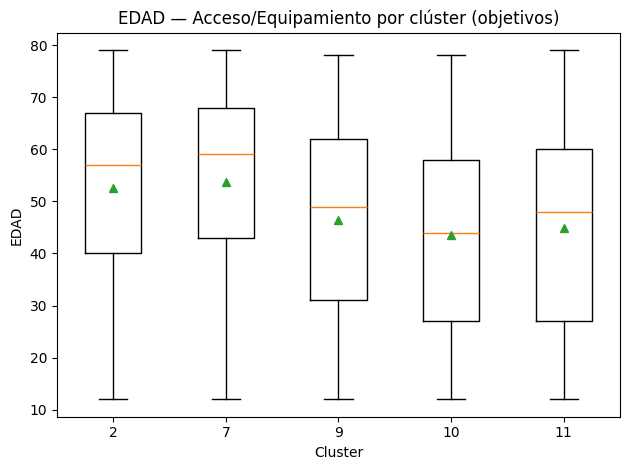

/tmp/ipython-input-2756306890.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(c) for c in clusters], showmeans=True)


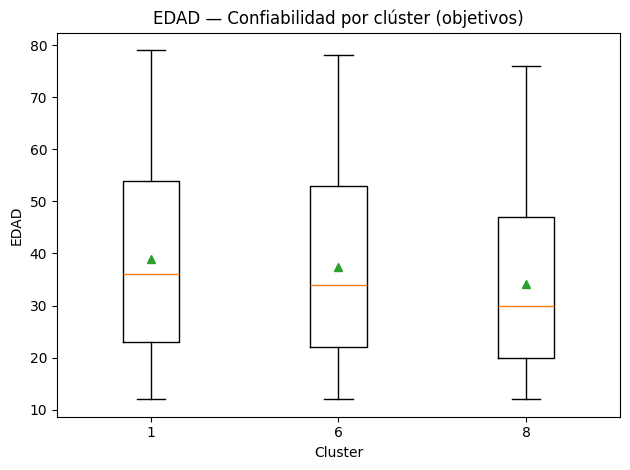

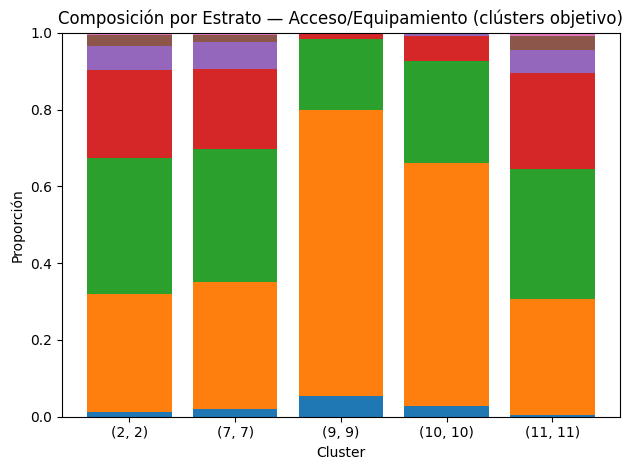

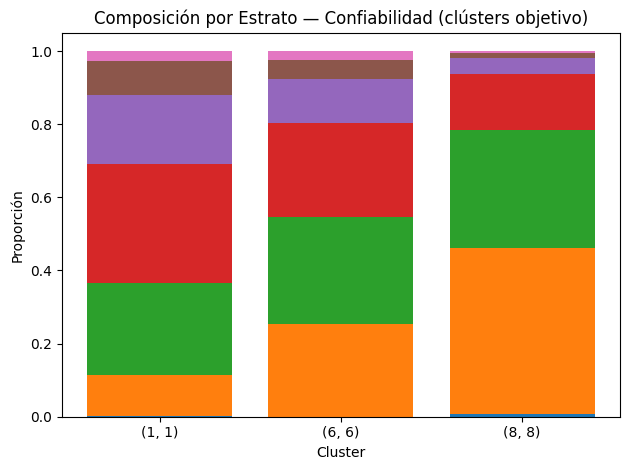

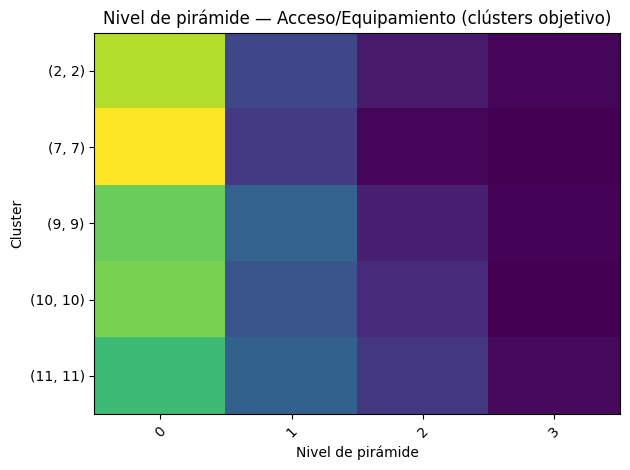

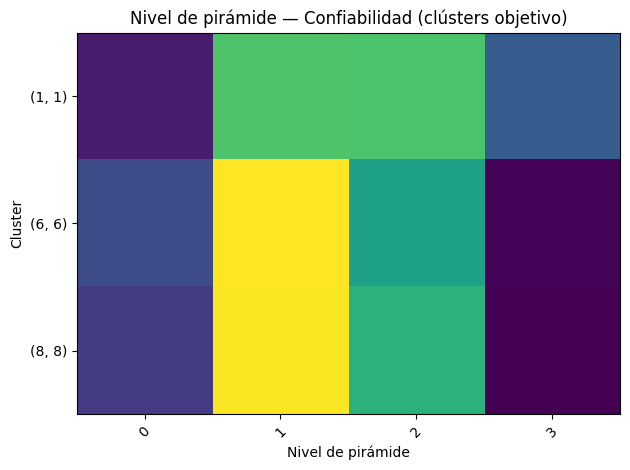

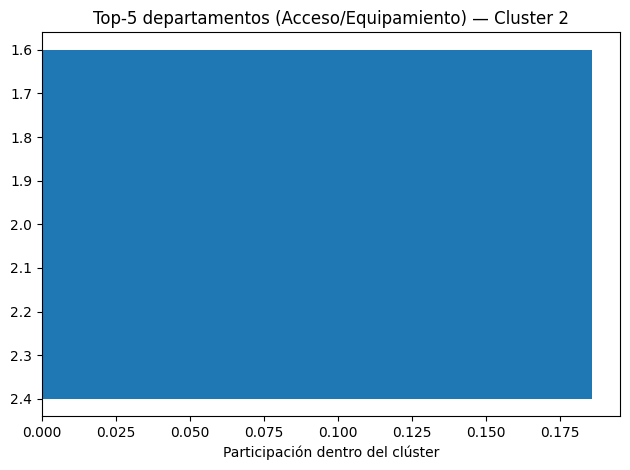

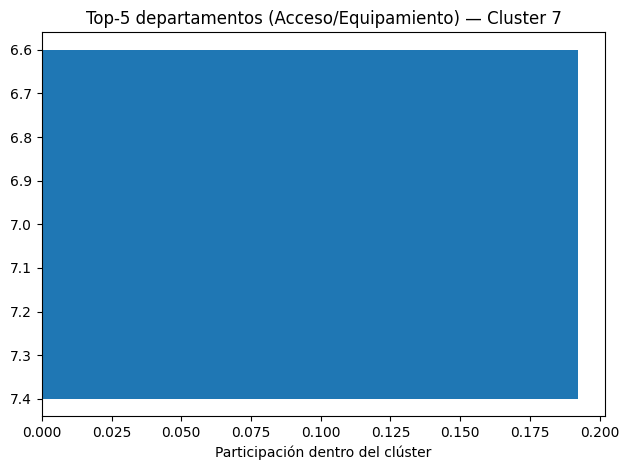

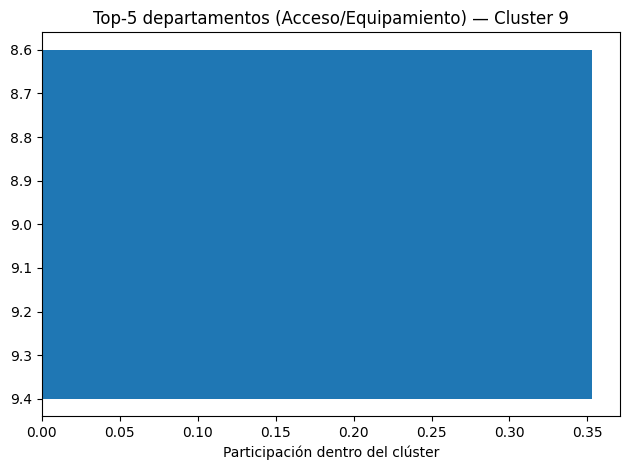

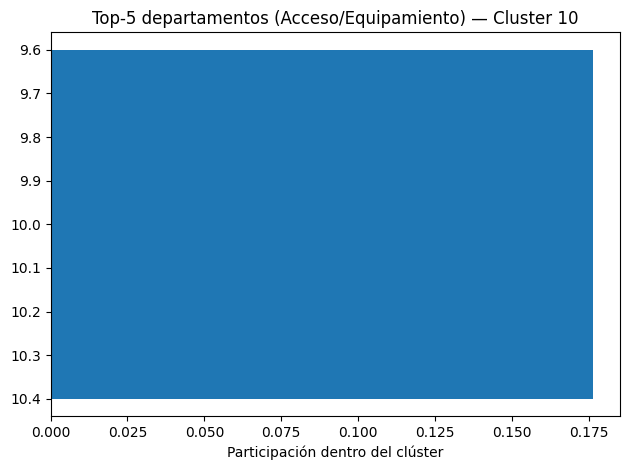

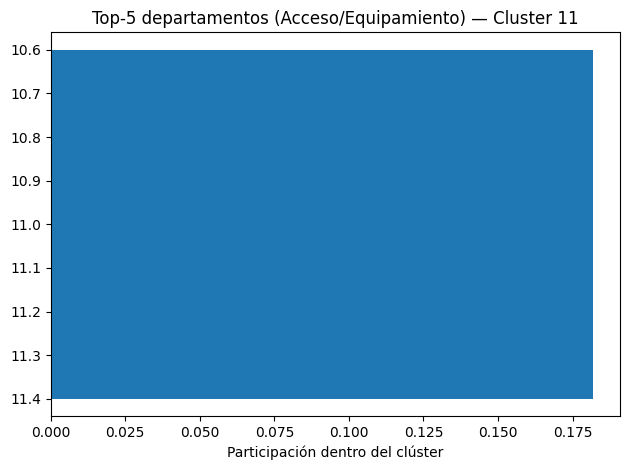

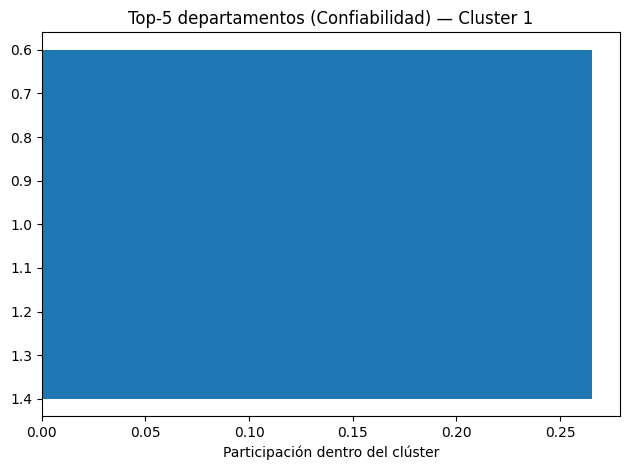

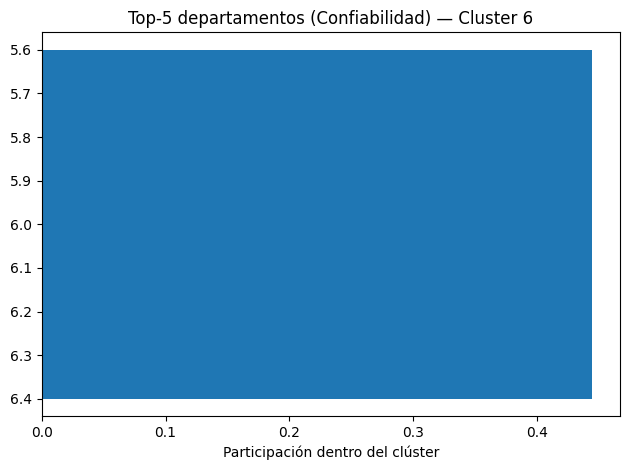

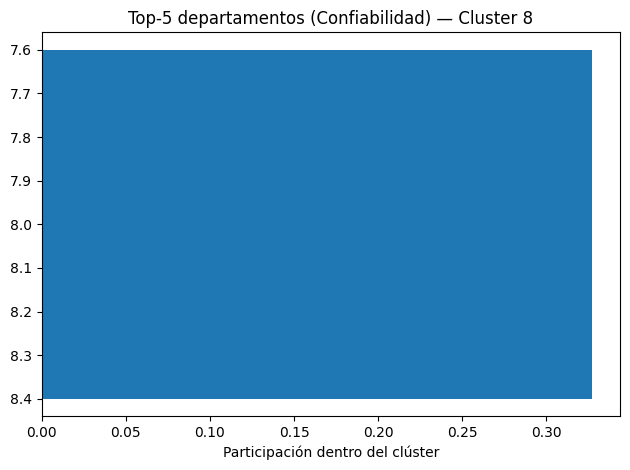

/tmp/ipython-input-2756306890.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(c) for c in clusters], showmeans=True)


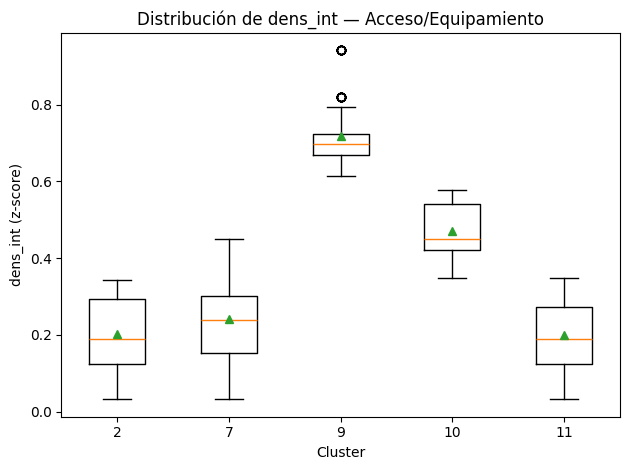

/tmp/ipython-input-2756306890.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(c) for c in clusters], showmeans=True)


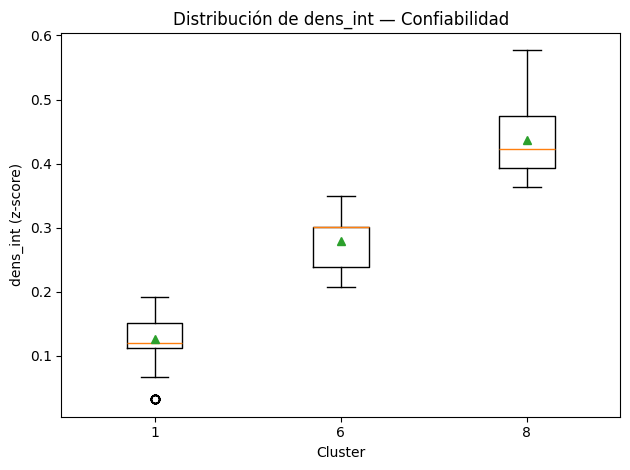

In [2]:
# ====== B) PERFILES SOCIODEMOGRÁFICOS Y TERRITORIALES ======
# Suponemos: df (datos originales con socio-demo y geo),
# labels1 (clusters EXP1), cent1 (centroides EXP1), interp1 (dict con tablas)

# 0) Selección de clústers objetivo a partir de centroides (EXP1)
def select_targets_from_centroids(centroids: pd.DataFrame):
    # Reglas simples (ajusta si deseas):
    acceso = centroids[
        (centroids["conexion_hogar_si"] <= 0.2) |
        (centroids["Dispositivos_hogar_No"] >= 0.5) |
        (centroids["Servicios_Telecomunicaciones_No"] >= 0.9)
    ].index.tolist()

    confiab = centroids[
        (centroids["conexion_hogar_si"] >= 0.9) &
        (centroids["interrupciones_si"] >= 0.9)
    ].index.tolist()

    return sorted(set(acceso)), sorted(set(confiab))

targets_acceso, targets_confiab = select_targets_from_centroids(cent1)
print("Targets acceso/equipamiento:", targets_acceso)
print("Targets confiabilidad/continuidad:", targets_confiab)

# 1) Boxplot de EDAD por clúster (solo clústers objetivo)
def plot_age_boxplot_by_clusters(df: pd.DataFrame, labels: np.ndarray, clusters: list, title_prefix="EDAD"):
    tmp = df[["EDAD"]].copy()
    tmp["cluster"] = labels
    data = [tmp.loc[tmp["cluster"]==c, "EDAD"].dropna().values for c in clusters]
    plt.figure()
    plt.boxplot(data, labels=[str(c) for c in clusters], showmeans=True)
    plt.xlabel("Cluster")
    plt.ylabel("EDAD")
    plt.title(f"{title_prefix} por clúster (objetivos)")
    plt.tight_layout()
    plt.show()

plot_age_boxplot_by_clusters(df, labels1, targets_acceso, title_prefix="EDAD — Acceso/Equipamiento")
plot_age_boxplot_by_clusters(df, labels1, targets_confiab, title_prefix="EDAD — Confiabilidad")

# 2) Barras apiladas normalizadas de ESTRATO por clúster
def plot_stacked_bar_categorical(df: pd.DataFrame, labels: np.ndarray, clusters: list, cat_col="ESTRATO", title="Composición por Estrato"):
    tmp = df[[cat_col]].copy()
    tmp["cluster"] = labels
    # Tabla de proporciones: filas=cluster, columnas=categorías
    tab = (tmp[tmp["cluster"].isin(clusters)]
           .groupby(["cluster", cat_col]).size()
           .groupby(level=0).apply(lambda s: s / s.sum())
           .unstack(fill_value=0)
           .sort_index())

    plt.figure()
    bottom = np.zeros(tab.shape[0])
    x = np.arange(tab.shape[0])
    for cat in tab.columns:
        vals = tab[cat].values
        plt.bar(x, vals, bottom=bottom)
        bottom += vals
    plt.xticks(x, [str(c) for c in tab.index])
    plt.xlabel("Cluster")
    plt.ylabel("Proporción")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_stacked_bar_categorical(df, labels1, targets_acceso, cat_col="ESTRATO",
                             title="Composición por Estrato — Acceso/Equipamiento (clústers objetivo)")
plot_stacked_bar_categorical(df, labels1, targets_confiab, cat_col="ESTRATO",
                             title="Composición por Estrato — Confiabilidad (clústers objetivo)")

# 3) Heatmap de NIVEL_PIRAMIDE (usa tabla ya construida en interp1)
def plot_heatmap_piramide(pivot: pd.DataFrame, title="Nivel de Pirámide (proporciones)"):
    plt.figure()
    mat = pivot.values  # filas=cluster, columnas=nivel
    plt.imshow(mat, aspect="auto")
    plt.yticks(np.arange(pivot.shape[0]), [str(i) for i in pivot.index])
    plt.xticks(np.arange(pivot.shape[1]), [str(c) for c in pivot.columns], rotation=45)
    plt.xlabel("Nivel de pirámide")
    plt.ylabel("Cluster")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Filtrar a clústers objetivo
piv = interp1["nivel_piramide"].loc[targets_acceso]  # clústers de acceso
plot_heatmap_piramide(piv, title="Nivel de pirámide — Acceso/Equipamiento (clústers objetivo)")

piv2 = interp1["nivel_piramide"].loc[targets_confiab]  # clústers de confiabilidad
plot_heatmap_piramide(piv2, title="Nivel de pirámide — Confiabilidad (clústers objetivo)")

# 4) Top-5 departamentos por clúster (barras)
def plot_top_departments(interp_top_dept: pd.DataFrame, cluster_id: int, title_prefix="Top departamentos"):
    # interp_top_dept: índice jerárquico (cluster, depto), columna 'share'
    g = interp_top_dept.xs(cluster_id, level=0).sort_values("share", ascending=False).head(5)
    plt.figure()
    plt.barh(g.index.get_level_values(0), g["share"].values)
    plt.gca().invert_yaxis()
    plt.xlabel("Participación dentro del clúster")
    plt.title(f"{title_prefix} — Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()

for c in targets_acceso:
    plot_top_departments(interp1["top_departamentos"], c, title_prefix="Top-5 departamentos (Acceso/Equipamiento)")

for c in targets_confiab:
    plot_top_departments(interp1["top_departamentos"], c, title_prefix="Top-5 departamentos (Confiabilidad)")

# 5) Distribución de dens_int (boxplot por clúster objetivo)
def plot_dens_boxplot(df: pd.DataFrame, labels: np.ndarray, clusters: list, title="dens_int por clúster"):
    tmp = df[["dens_int"]].copy()
    tmp["cluster"] = labels
    data = [tmp.loc[tmp["cluster"]==c, "dens_int"].dropna().values for c in clusters]
    plt.figure()
    plt.boxplot(data, labels=[str(c) for c in clusters], showmeans=True)
    plt.xlabel("Cluster")
    plt.ylabel("dens_int (z-score)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_dens_boxplot(df, labels1, targets_acceso, title="Distribución de dens_int — Acceso/Equipamiento")
plot_dens_boxplot(df, labels1, targets_confiab, title="Distribución de dens_int — Confiabilidad")

In [3]:
from google.colab import files
import geopandas as gpd

In [4]:
uploaded = files.upload()

Saving gadm41_COL_0.cpg to gadm41_COL_0.cpg
Saving gadm41_COL_0.dbf to gadm41_COL_0.dbf
Saving gadm41_COL_0.prj to gadm41_COL_0.prj
Saving gadm41_COL_0.shp to gadm41_COL_0.shp
Saving gadm41_COL_0.shx to gadm41_COL_0.shx
Saving gadm41_COL_1.cpg to gadm41_COL_1.cpg
Saving gadm41_COL_1.dbf to gadm41_COL_1.dbf
Saving gadm41_COL_1.prj to gadm41_COL_1.prj
Saving gadm41_COL_1.shp to gadm41_COL_1.shp
Saving gadm41_COL_1.shx to gadm41_COL_1.shx
Saving gadm41_COL_2.cpg to gadm41_COL_2.cpg
Saving gadm41_COL_2.dbf to gadm41_COL_2.dbf
Saving gadm41_COL_2.prj to gadm41_COL_2.prj
Saving gadm41_COL_2.shp to gadm41_COL_2.shp
Saving gadm41_COL_2.shx to gadm41_COL_2.shx


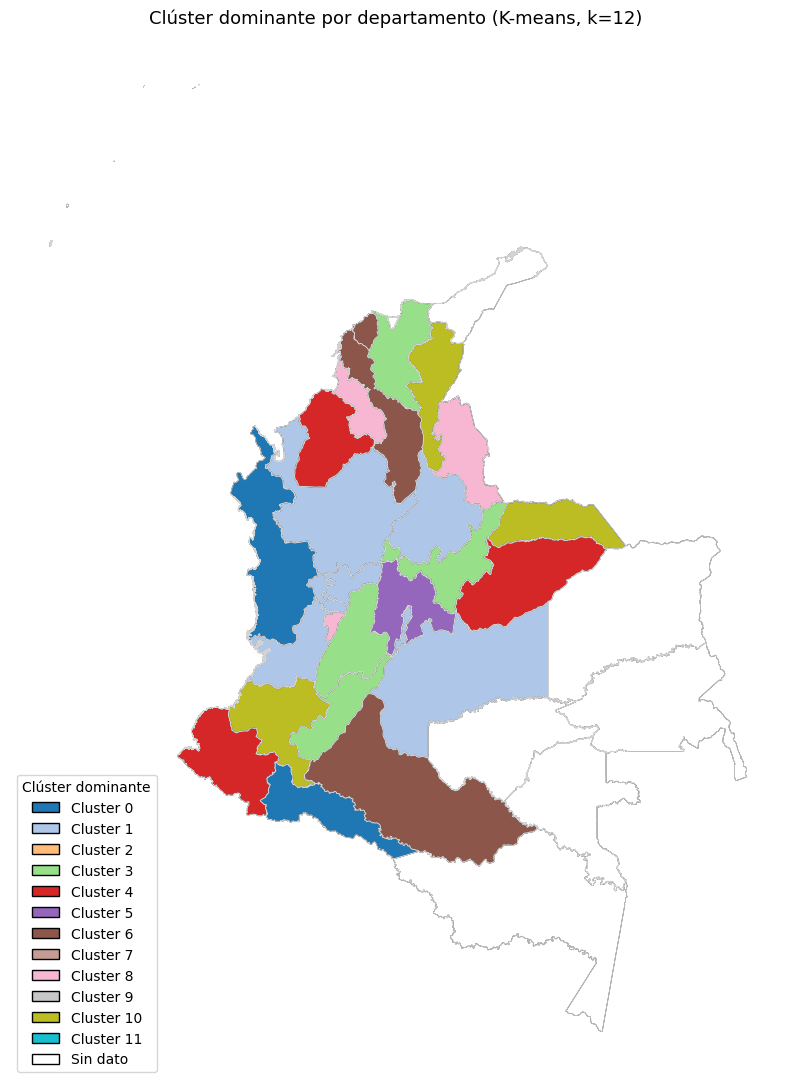

In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- 1) Features para clustering (las que usaste en EXP1) ---
FEATURES = [
    "Servicios_Telecomunicaciones_No",
    "Servicios_Telecomunicaciones_Si",
    "Dispositivos_hogar_No",
    "conexion_hogar_si",
    "interrupciones_si",
    "frec_uso_si",
    "dens_int",
]

# --- 2) Preparar matriz de entrenamiento ---
X = df[FEATURES].copy()
scaler = StandardScaler()
X[["dens_int"]] = scaler.fit_transform(X[["dens_int"]])  # solo escalar dens_int

# --- 3) Entrenar K-means con k=12 (configuración seleccionada) ---
kmeans = KMeans(n_clusters=12, n_init=50, random_state=123)
labels = kmeans.fit_predict(X)

# Añadir columna de cluster al dataframe original
df_lab = df.copy()
df_lab["cluster"] = labels

# --- 4) Normalización para empatar con shapefile ---
def norm(s: pd.Series) -> pd.Series:
    return (s.astype(str).str.upper()
             .str.normalize("NFKD").str.encode("ascii","ignore").str.decode("utf-8")
             .str.replace(r"[^A-Z0-9\s]", " ", regex=True)
             .str.replace(r"\s+", " ", regex=True)
             .str.strip())

df_lab["dep_norm"] = norm(df_lab["Nombre Departamento"])

# --- 5) Calcular clúster dominante por departamento ---
dom = (df_lab.groupby("dep_norm")["cluster"]
             .agg(lambda s: s.value_counts(normalize=True).idxmax())
             .rename("cluster_dom")
             .reset_index())

# --- 6) Cargar shapefile de departamentos ---
gdf_dpto = gpd.read_file("gadm41_COL_1.shp")
gdf_dpto["dep_norm"] = norm(gdf_dpto["NAME_1"])

# --- 7) Merge shape + clusters ---
gdf_join = gdf_dpto.merge(dom, on="dep_norm", how="left")

# --- 8) Asignar colores a clústers ---
clusters_sorted = sorted(df_lab["cluster"].unique())
cmap = plt.get_cmap("tab20")
color_map = {c: cmap(i/len(clusters_sorted)) for i, c in enumerate(clusters_sorted)}
gdf_join["color"] = gdf_join["cluster_dom"].map(color_map).fillna("#FFFFFF")

# --- 9) Plot mapa ---
fig, ax = plt.subplots(figsize=(11, 11))
gdf_dpto.boundary.plot(ax=ax, color="lightgrey", linewidth=0.6)  # fondo contorno
gdf_join.plot(ax=ax, color=gdf_join["color"], edgecolor="black", linewidth=0.5)

# Leyenda
legend_patches = [Patch(facecolor=color_map[c], edgecolor="black", label=f"Cluster {c}")
                  for c in clusters_sorted]
legend_patches.append(Patch(facecolor="#FFFFFF", edgecolor="black", label="Sin dato"))
ax.legend(handles=legend_patches, title="Clúster dominante", loc="lower left", frameon=True)

ax.set_title("Clúster dominante por departamento (K-means, k=12)", fontsize=13, pad=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### 1. Concentración de clústers de acceso/equipamiento
* Clústeres 3, 4, 7, 9 y 10 (asociados a limitaciones de conexión o falta de dispositivos) se concentran principalmente en departamentos periféricos y de menor densidad digital.
    * En la Costa Caribe y Pacífica predominan clústers con déficit de acceso y equipamiento, reflejando barreras tanto económicas como de infraestructura.
    * En departamentos del sur y suroccidente, aparecen también clústers de acceso en territorios de baja densidad, lo que confirma la existencia de zonas aún desconectadas, incluso en áreas urbanas intermedias.

### 2. Concentración de clústers de confiabilidad
* Clústeres 1, 2 y 6 (problemas de interrupciones y calidad del servicio) aparecen en varios departamentos de la región andina y del oriente.
    * Esto indica que en zonas de alta densidad digital y cobertura aceptable, los usuarios aún enfrentan problemas de continuidad del servicio.
    * La concentración en departamentos con alta penetración de internet sugiere que la brecha no está en el acceso, sino en la robustez y confiabilidad de la red.

### 3. Departamentos con clústers de alto contraste
* Bogotá, Antioquia, Valle del Cauca y Santander: aparecen dominados por clústers donde la conexión y servicios existen, pero surgen problemas de calidad e interrupciones. Esto refleja la presión sobre la infraestructura en territorios de mayor demanda digital.
* Departamentos de la Orinoquía y Amazonía: presentan clústers de acceso/equipamiento, donde la baja densidad poblacional y las dificultades logísticas hacen más costosa la expansión de redes.
* Departamentos caribeños como Atlántico, Sucre o Bolívar: aparecen también en clústers con mezcla de acceso y confiabilidad, reflejando desigualdades al interior de las mismas regiones.

### 4. Implicaciones estratégicas
1. Acceso/equipamiento (Caribe, Pacífico, Amazonía y Orinoquía): la estrategia debe enfocarse en subsidios a dispositivos, programas de alfabetización digital y extensión de cobertura.
2. Confiabilidad (Andina, Bogotá, Antioquia, Valle): aquí la política debe centrarse en mejorar la calidad de la red, con énfasis en reducir interrupciones y aumentar la resiliencia de los proveedores.
3. Departamentos mixtos: requieren estrategias combinadas: por ejemplo, Atlántico y Bolívar necesitan tanto mejorar el acceso en zonas rurales como garantizar continuidad en áreas urbanas densas.

In [6]:
df_lab.to_csv("df_lab.csv", index=False, encoding="utf-8")

## Validación requerimientos

### Correlaciones significativas (p < 0.05) entre los perfiles y variables de contexto

In [7]:
df_lab

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   AÑO                              7662 non-null   int64  
 1   GPSLAT                           6620 non-null   float64
 2   GPSLONG                          6620 non-null   float64
 3   SECTOR                           7662 non-null   int64  
 4   SECCION                          7662 non-null   int64  
 5   MANZANA                          7662 non-null   int64  
 6   DIRECCION_FILTRO                 7662 non-null   object 
 7   DANE5                            7662 non-null   int64  
 8   PB1                              7662 non-null   int64  
 9   PERSONAS                         7662 non-null   int64  
 10  EDAD                             7662 non-null   int64  
 11  REDAD                            7662 non-null   int64  
 12  GENERO              

In [11]:
import pandas as pd
from scipy.stats import chi2_contingency

cat_vars = ["ESTRATO", "GENERO", "NIVEL_PIRAMIDE", "PB1", "Nombre Departamento"]

chi_results = {}

for var in cat_vars:
    tabla = pd.crosstab(df_lab["cluster"], df_lab[var])
    chi2, p, dof, expected = chi2_contingency(tabla)
    chi_results[var] = {"Chi2": chi2, "p-valor": p}

chi_results

{'ESTRATO': {'Chi2': np.float64(1877.3271604741456),
  'p-valor': np.float64(0.0)},
 'GENERO': {'Chi2': np.float64(16.09867715764373),
  'p-valor': np.float64(0.1375068831555621)},
 'NIVEL_PIRAMIDE': {'Chi2': np.float64(2723.0232164350737),
  'p-valor': np.float64(0.0)},
 'PB1': {'Chi2': np.float64(1477.5700244336867),
  'p-valor': np.float64(2.19720336763576e-310)},
 'Nombre Departamento': {'Chi2': np.float64(10506.416124972427),
  'p-valor': np.float64(0.0)}}

In [12]:
from scipy.stats import f_oneway, kruskal

# Separar edad por clusters
grupos = [df_lab.loc[df_lab["cluster"] == c, "EDAD"].dropna() for c in df_lab["cluster"].unique()]

# ANOVA
anova_f, anova_p = f_oneway(*grupos)

# Kruskal-Wallis
kw_h, kw_p = kruskal(*grupos)

{"ANOVA_p": anova_p, "Kruskal_p": kw_p}

{'ANOVA_p': np.float64(8.263475001252209e-156),
 'Kruskal_p': np.float64(6.721962540372269e-134)}